In [42]:
%pip install pandas matplotlib seaborn networkx scikit-learn sentence-transformers plotly nltk textblob

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re
from collections import Counter
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import plotly.express as px
from textblob import TextBlob

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/harish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
class Analytics:
    def __init__(self, file):
        self.data = None
        self.file = file
        self.df = None
        self.users_messages = None
        self.users_most_frequent_words = {}
        self.setup()
        
    def setup(self):
        try:
            with open(self.file) as f:
                self.data = f.read()
        except FileNotFoundError:
            print("File not found")
            exit(1)
        except PermissionError:
            print("check your file permissions.")
            exit(1)
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            exit(1)             
        combined_data = self.combine_multiline_messages(self.data)
        self.df = pd.DataFrame(combined_data)
        self.df["date"] = self.df[0].str.split(" ", expand=True)[0]
        self.df['date'] = pd.to_datetime(self.df['date'], dayfirst=True)
        self.df["time"] = self.df[0].str.split(" ", expand=True)[1]
        self.df["content"] = self.df[0].str.partition(",", expand=True)[2].str.partition("-", expand=True)[2]
        # Only split when ':' is present
        self.df['user'] = self.df['content'].apply(lambda x: x.split(":")[0] if ":" in x else "system")
        self.df['message'] = self.df['content'].apply(lambda x: x.split(":", 1)[1].strip() if ":" in x else x.strip())

        self.df = self.df.drop(columns=[0, "content"])
        self.df['message_length'] = self.df['message'].str.len()
        self.users_messages = self.get_user_message(self.df)
        
    def combine_multiline_messages(self, text):
        combined_lines = []
        pattern = re.compile(r"^\d{2}/\d{2}/\d{4}, \d{1,2}:\d{2}\s?(am|pm)?\s?-\s")
        for line in text.splitlines()[1:]:
            if pattern.match(line):
                if " <Media omitted>" not in line:
                    combined_lines.append(line)
            else:
                if combined_lines:
                    combined_lines[-1] += ' ' + line.strip()
        return combined_lines
    
    def get_user_message(self, df):
        users_text = defaultdict(str)
        for index, row in df.iterrows():
            user = str(row["user"]).lstrip(" ")
            message = row["message"]
            users_text[user] += message
        return users_text
        
    def get_top_frequent_words(self, n=5):
        for user, text in self.users_messages.items():
            text = text.lower()
            words = re.findall(r'\b\w{4,}\b', text)  # only words with length >= 4
            word_counter = Counter(words)
            self.users_most_frequent_words[user] = word_counter.most_common(n)

        # Visualization
        data = []
        for user, word_freqs in self.users_most_frequent_words.items():
            for word, freq in word_freqs:
                data.append((user, word, freq))

        df_words = pd.DataFrame(data, columns=['User', 'Word', 'Frequency'])

        plt.figure(figsize=(12, 6))
        sns.barplot(data=df_words, x='Frequency', y='Word', hue='User', dodge=True)
        plt.title("Top Frequent Words Per User (Min 4 Characters)")
        plt.xlabel("Frequency")
        plt.ylabel("Word")
        plt.legend(title='User', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


    def message_length_analysis(self):
        user_avg = self.df.groupby('user')['message_length'].mean().sort_values(ascending=False)
        print("Average message length per user:\n", user_avg)
        daily_avg = self.df.groupby(self.df['date'].dt.date)['message_length'].mean()

        # Plot average length over time
        plt.figure(figsize=(10, 4))
        daily_avg.plot()
        plt.title("Average Message Length Over Time")
        plt.xlabel("Date")
        plt.ylabel("Avg Message Length")
        plt.tight_layout()
        plt.show()
    def active_time_analysis(self):
        # Clean up the time column if needed
        if isinstance(self.df['time'].iloc[0], str):
            self.df['time'] = self.df['time'].str.replace('\u202f', '', regex=True).str.strip()
        
        # Extract hour from the existing datetime 'date' column
        self.df['hour'] = self.df['date'].dt.hour
        
        # Extract weekday from the existing datetime 'date' column
        self.df['weekday'] = self.df['date'].dt.day_name()

        # Weekday activity
        plt.figure(figsize=(10, 4))
        sns.countplot(x='weekday', data=self.df, order=[
            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
        ])
        plt.title("Most Active Weekdays")
        plt.tight_layout()
        plt.show()
    def user_interaction(self):
        user_counts = Counter(self.df['user'])

        G = nx.Graph()
        for user, count in user_counts.items():
            G.add_node(user, size=count)

        users = list(user_counts.keys())
        for i in range(len(users)):
            for j in range(i + 1, len(users)):
                G.add_edge(users[i], users[j])

        sizes = [G.nodes[u]['size'] * 50 for u in G.nodes]

        plt.figure(figsize=(8, 8))
        pos = nx.spring_layout(G, seed=42)  # consistent layout
        nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='skyblue')
        nx.draw_networkx_edges(G, pos, width=1.5, edge_color='gray')
        nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

        plt.title("User Interaction Graph", fontsize=14)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    def topic_modeling(self,n_topics=5):
        # Sample: df["message"]
        messages = self.df["message"]
        # 1. Convert messages to bag-of-words
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(messages)

        # 2. Apply LDA
        lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 2 topics for example
        lda.fit(X)

        # 3. Get top words per topic
        words = vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(lda.components_):
            top_words = [words[i] for i in topic.argsort()[:-6:-1]]
            print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
    
    def similar_conversations(self,n_clusters=5):
        stop_words = set(nltk.corpus.stopwords.words('english'))
        self.df['cleaned_message'] = self.df['message'].apply(
        lambda text: ' '.join(
        [word for word in re.sub(r'[^\w\s]', '', text.lower()).split() if word not in stop_words and len(word) > 3]
        )
    )


        # Generate sentence embeddings
        embedder = SentenceTransformer('all-MiniLM-L6-v2')
        embeddings = embedder.encode(self.df['cleaned_message'], show_progress_bar=False)


        # Clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        self.df['cluster'] = kmeans.fit_predict(embeddings)

        # Dimensionality reduction + scaling
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(embeddings)
        self.df[['x', 'y']] = MinMaxScaler().fit_transform(reduced)

        # Assign top keyword per cluster
        top_keywords = {}
        for c in self.df['cluster'].unique():
            words = ' '.join(self.df[self.df['cluster'] == c]['cleaned_message']).split()
            if words:
                top_words = [word for word, _ in Counter(words).most_common(10)]
                cluster_label = ', '.join(top_words).title()
            else:
                cluster_label = f'Cluster {c}'
            top_keywords[c] = cluster_label

        self.df['cluster_label'] = self.df['cluster'].map(top_keywords)

        # Plot
        fig = px.scatter(
            self.df,
            x='x',
            y='y',
            color='cluster_label',
            hover_data=['user', 'message'],
            title='Semantic Clustering of Messages',
            labels={'x': 'PCA Component 1', 'y': 'PCA Component 2'}
        )
        fig.update_traces(marker=dict(size=10, opacity=0.8))
        fig.update_layout(legend_title_text='Cluster Topics')
        fig.show()
    def sentiment_dashboard(self):
        self.df['sentiment'] = self.df['message'].astype(str).apply(lambda x: float(TextBlob(x).sentiment.polarity))        
        # Sentiment per user
        user_sentiment = self.df.groupby('user')['sentiment'].mean().sort_values()
        plt.figure(figsize=(10, 4))
        user_sentiment.plot(kind='barh', color='skyblue')
        plt.title("Average Sentiment per User")
        plt.xlabel("Avg Sentiment Score")
        plt.tight_layout()
        plt.show()



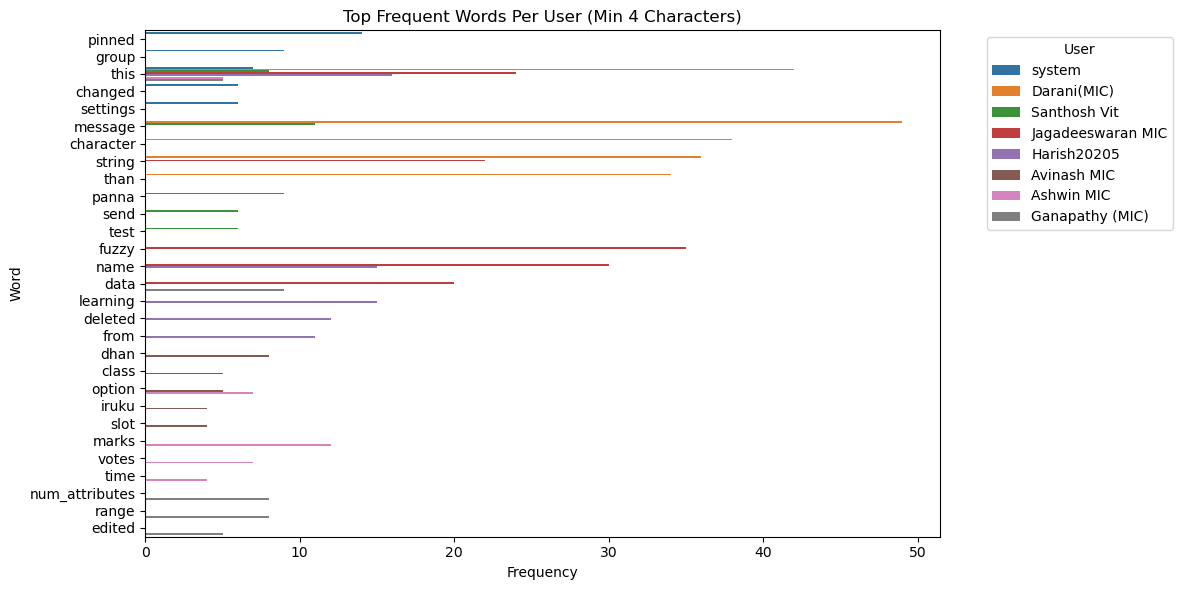

{'system': [('pinned', 14),
  ('group', 9),
  ('this', 7),
  ('changed', 6),
  ('settings', 6)],
 'Darani(MIC)': [('message', 49),
  ('this', 42),
  ('character', 38),
  ('string', 36),
  ('than', 34)],
 'Santhosh Vit': [('message', 11),
  ('panna', 9),
  ('this', 8),
  ('send', 6),
  ('test', 6)],
 'Jagadeeswaran MIC': [('fuzzy', 35),
  ('name', 30),
  ('this', 24),
  ('string', 22),
  ('data', 20)],
 'Harish20205': [('this', 16),
  ('name', 15),
  ('learning', 15),
  ('deleted', 12),
  ('from', 11)],
 'Avinash MIC': [('dhan', 8),
  ('class', 5),
  ('option', 5),
  ('iruku', 4),
  ('slot', 4)],
 'Ashwin MIC': [('marks', 12),
  ('option', 7),
  ('votes', 7),
  ('this', 5),
  ('time', 4)],
 'Ganapathy (MIC)': [('data', 9),
  ('num_attributes', 8),
  ('range', 8),
  ('this', 5),
  ('edited', 5)]}

In [45]:

model = Analytics("group_chat.txt")
model.get_top_frequent_words(5)
model.users_most_frequent_words


Average message length per user:
 user
 Jagadeeswaran MIC    114.399225
 Harish20205          105.321212
 Darani(MIC)           70.566576
 Ganapathy (MIC)       44.443396
system                 36.696970
 Avinash MIC           21.222727
 Santhosh Vit          16.023310
 Ashwin MIC            14.043103
Name: message_length, dtype: float64


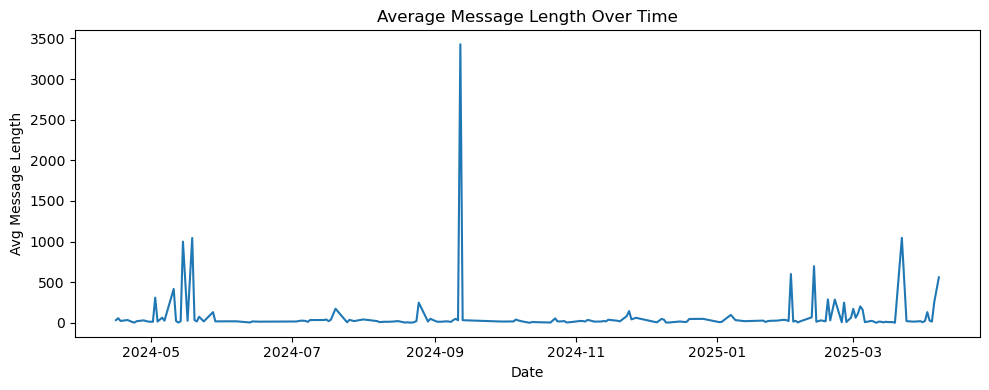

In [46]:
model.message_length_analysis()


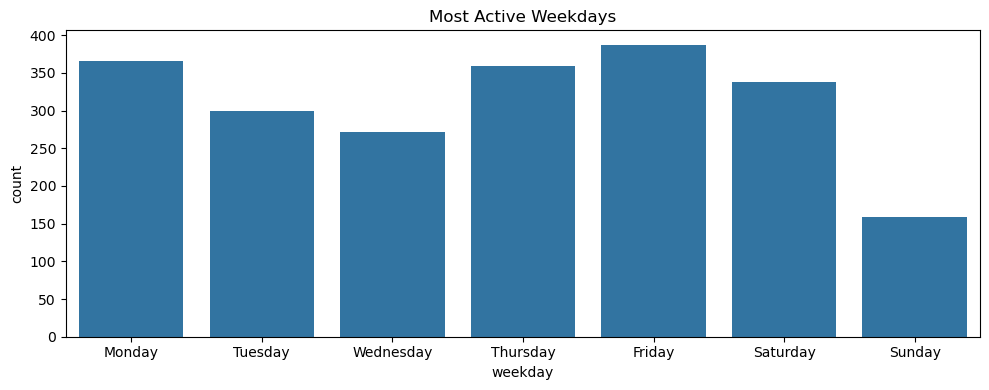

In [47]:
model.active_time_analysis()


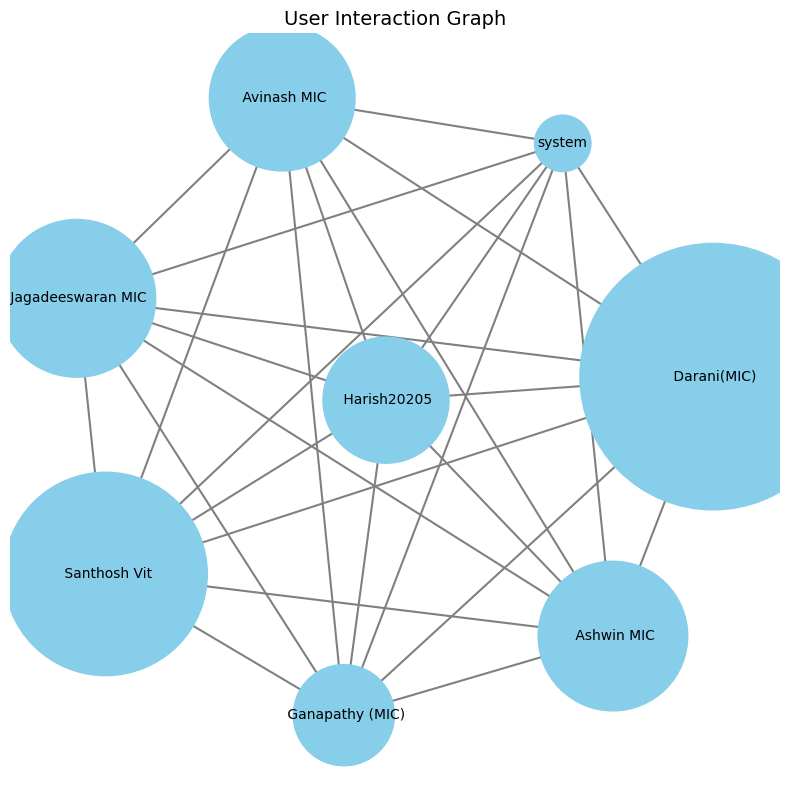

In [48]:
model.user_interaction()


In [49]:
model.topic_modeling()


Topic 1: pan, character, option, votes, throw
Topic 2: da, ok, illa, enna, ithu
Topic 3: id, mod, book, data, session
Topic 4: fuzzy, https, da, code, branch
Topic 5: message, deleted, import, edited, ah


In [50]:
model.similar_conversations(4)


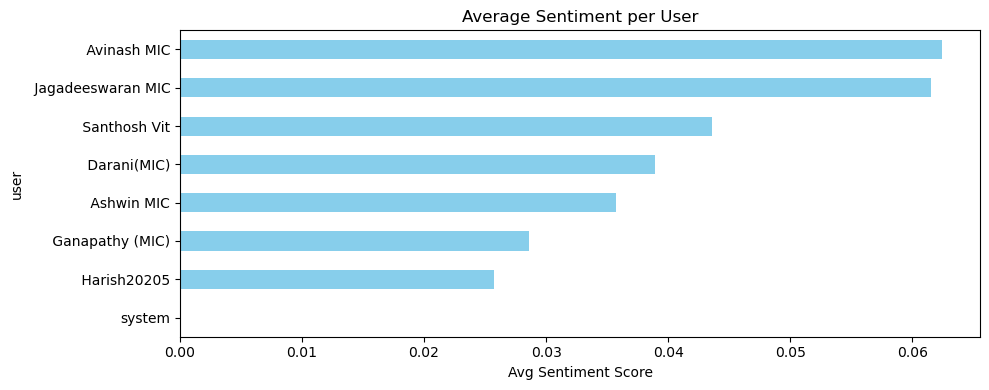

In [51]:
model.sentiment_dashboard()
